### Pytorch.  LSTM

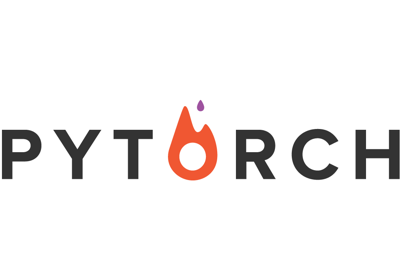

#### План урока:
* LSTM
* Свой Data Loader 
* Модуль transform

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### Что такое распознавание действий человека и для чего оно нужно?
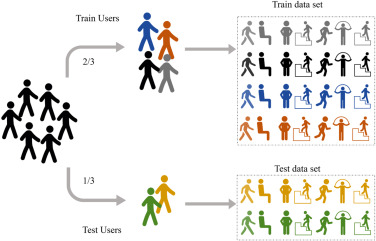

#### Задачи, в которых это нужно:
* Фитнес-приложения
* Системы видео-наблюдения 
* Системы контроля

### Типы данных: 
* Видео ряд 
* Данные с сенсоров/мобильных телефонов
* "Скелетные" (skeletal) данные

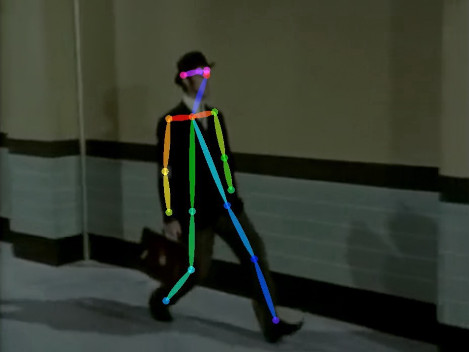

## Datasets

* http://rose1.ntu.edu.sg/datasets/actionrecognition.asp
* https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

## LSTM

##### Немного о RNN 

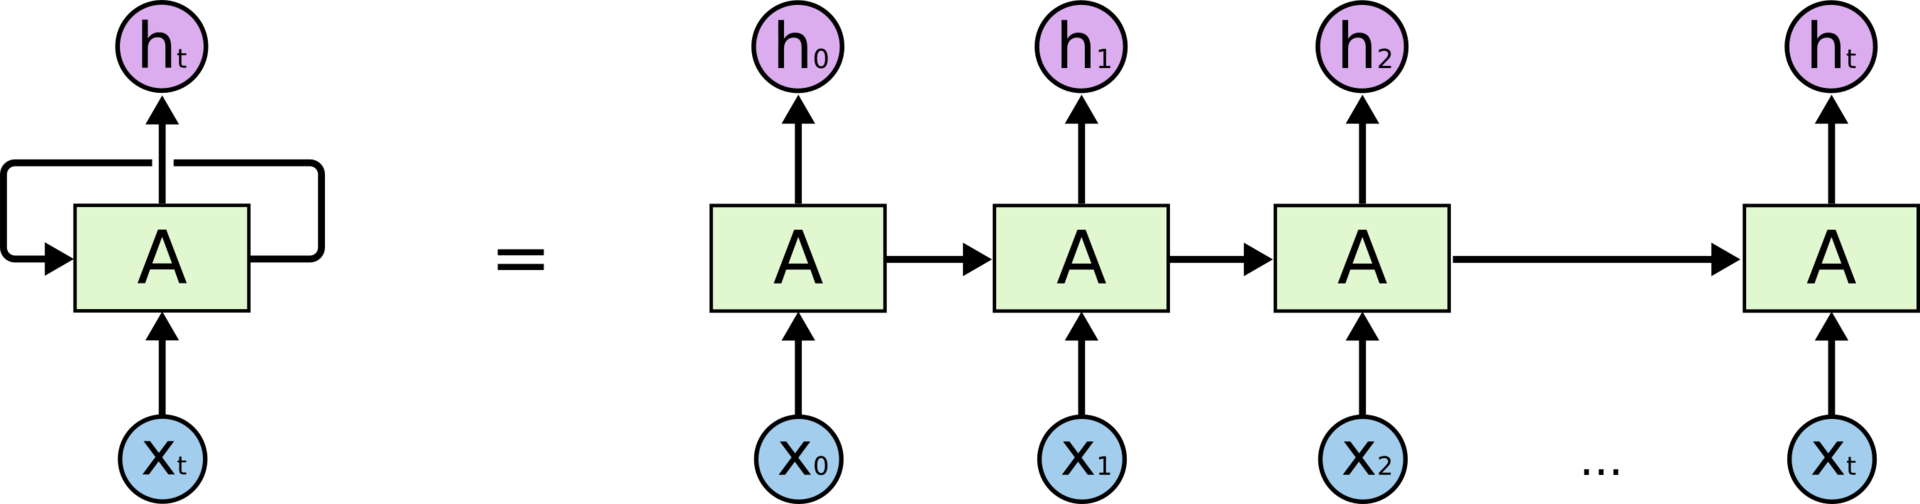

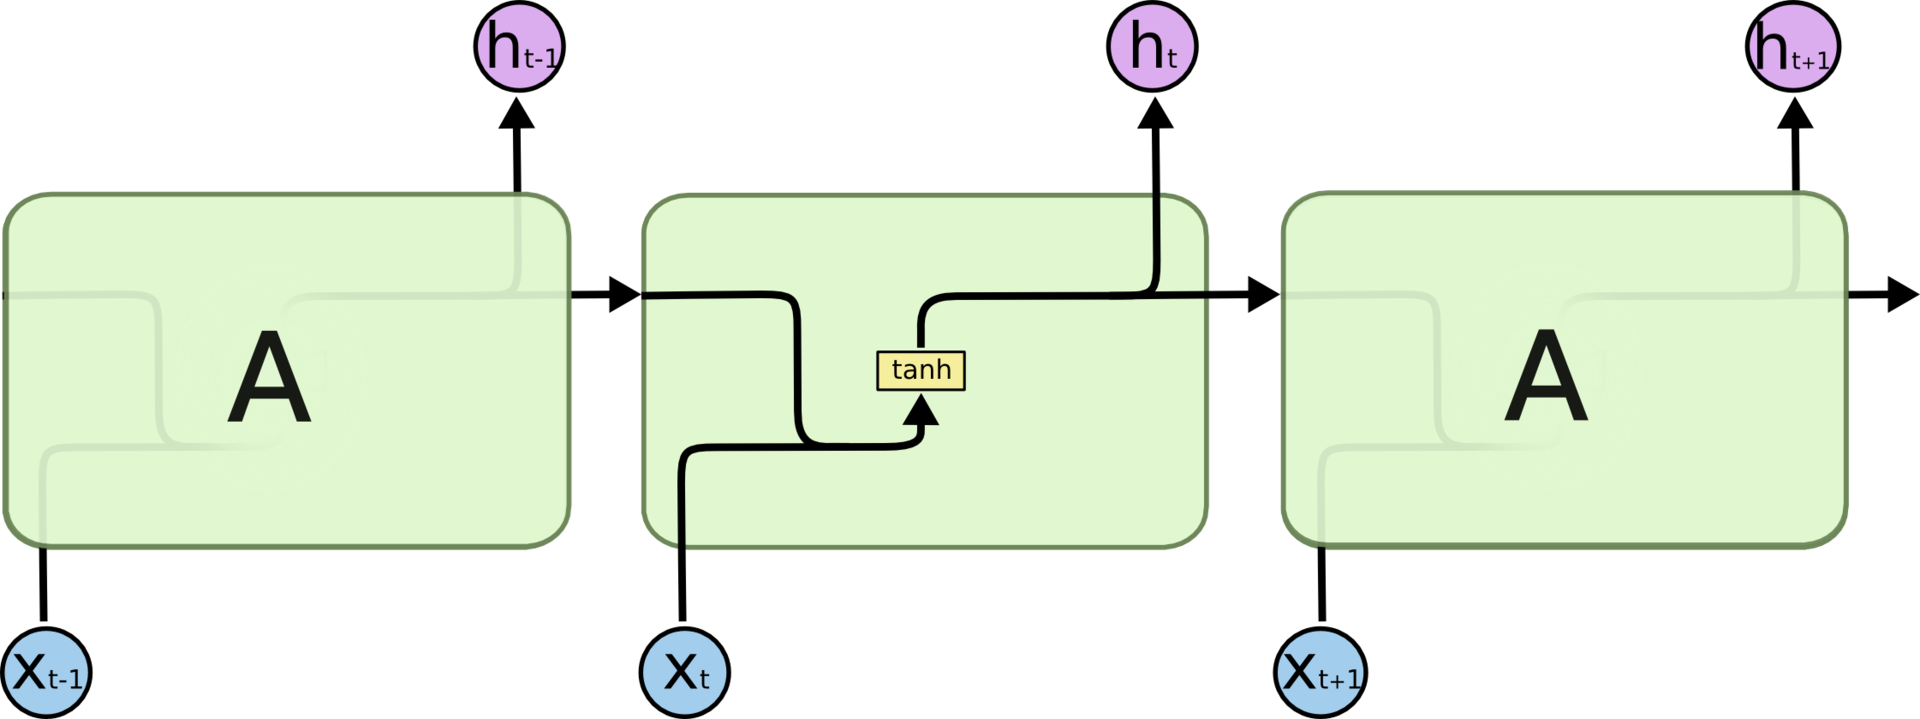

### И теперь уже LSTM

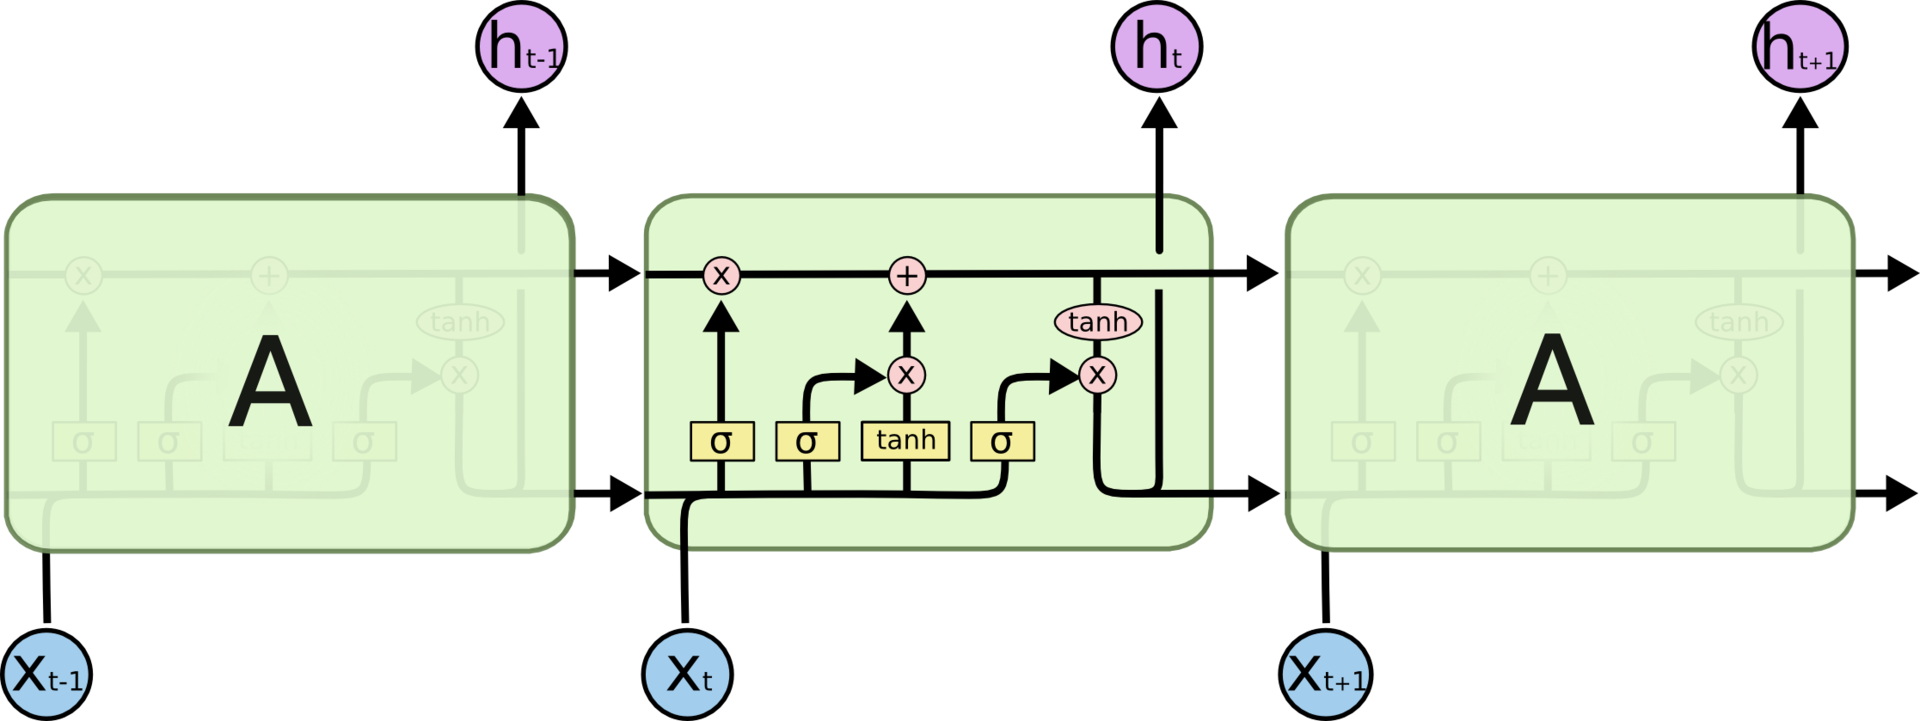

#### Статья с более подробным объяснением
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Реализация на PyToch
##### https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [2]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
#         self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

https://github.com/shahroudy/NTURGB-D

#### Classes:
* sitting down
* clapping
* jump up
* cheer up
* hand waving

In [3]:
import pandas as pd

skeletons = pd.read_csv("skels.csv")

In [4]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}

In [5]:
skeletons.head()

0         1         2         3         4         5         6  \
0 -0.526048 -0.277147  2.987706 -0.606184 -0.010056  3.010000 -0.681454   
1 -0.325320 -0.560200  3.244968 -0.296753 -0.312155  3.234485 -0.267607   
2 -0.134503  0.387048  3.797468 -0.135835  0.648782  3.669347 -0.137341   
3  0.371560 -0.187321  2.853457  0.388124  0.118966  2.756247  0.402399   
4 -0.193082 -0.178566  2.814345 -0.196894  0.114788  2.849780 -0.198289   

          7         8         9  ...      3366      3367      3368      3369  \
0  0.251614  3.020046 -0.708330  ... -0.619659  0.647852  2.708625 -0.598600   
1 -0.066345  3.212031 -0.286594  ... -0.066076 -0.459657  3.206000 -0.227804   
2  0.904024  3.529603 -0.131990  ... -0.332011  0.576840  3.451273  0.011452   
3  0.418116  2.643035  0.354668  ...  0.106246  0.619960  2.735462  0.352891   
4  0.400548  2.872416 -0.178771  ... -0.567993 -0.426740  2.994171  0.102882   

       3370      3371      3372      3373      3374  labels  
0  0.593635  2.707864 -0.601837  0.592191  2.697301       0  
1 -0.654428  3.002556 -0.231687 -0.655208  3.000000       1  
2  0.521624  3.528420 -0.011325  0.589017  3.480000       1  
3 -0.375651  2.625237  0.465385 -0.316062  2.651301       2  
4 -0.492025  3.011537  0.063065 -0.435819  3.055625       3  

[5 rows x 3376 columns]

## Dataloader

In [6]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from sklearn.preprocessing import normalize

In [7]:
from torch.utils.data import DataLoader, Dataset

``` DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None) ```

Класс Dataset и класс Dataloader помогают передавать собственные обучающие данные в сеть. 
Класс Dataset используется для обеспечения интерфейса для доступа ко всем обучающим или тестовым образцам в вашем наборе данных. Для этого необходимо реализовать как два обязательных метода, __getitem__ и __len_. 

In [8]:
class Test_Dataset(Dataset):
    def __init__(self):
        self.samples = list(range(0, 100)) ##генерируем случайные данные
        # Все подготовления данных происходят в инициализации:
        # - разделение данных на train/test/ validate
        # - аугментация (трансформация) данных 
        # - чтние аннотаций
        # - считывание по индексу

    def __len__(self):
        # # Возвращает данные и лейблы
        # - Применяет выбранные трансформации к данным
        # - отправление данных на гпу
        # - лучше возвращать данные как тензор или словарь
        return len(self.samples) #возвращаем данные

    def __getitem__(self, idx):
        return (self.samples[idx], label) 
    

In [9]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.data.iloc[idx,-1]
        
        if self.transform != None:
            item = normalize(item, axis=1, norm='l1')

        return (item, label) 

In [10]:
dataset = Skeleton_Dataset(file_path = "skels.csv", transform=True)

In [11]:
skel, lab = dataset.__getitem__(41)

In [12]:
skel

array([[-0.00025587, -0.00486339,  0.03464404, ..., -0.00148334,
        -0.00477647,  0.03286292],
       [-0.000231  , -0.00488497,  0.0346691 , ..., -0.00145628,
        -0.00493299,  0.03303042],
       [-0.00013513, -0.00491757,  0.03477772, ..., -0.00125942,
        -0.00444709,  0.03284193],
       ...,
       [ 0.00347441, -0.00673527,  0.03415621, ...,  0.00187585,
        -0.00647485,  0.03065663],
       [ 0.00340766, -0.006803  ,  0.03400253, ...,  0.00185898,
        -0.00627371,  0.03059674],
       [ 0.00343726, -0.00674424,  0.0341111 , ...,  0.00179496,
        -0.00633105,  0.03054423]])

In [13]:
type(skel)

numpy.ndarray

In [14]:
LABELS[lab]

'sitting down'

In [15]:
skel.shape

(45, 75)

In [16]:
skels_for_draw = skel.reshape(-1,25,3)

<IPython.core.display.Javascript object>


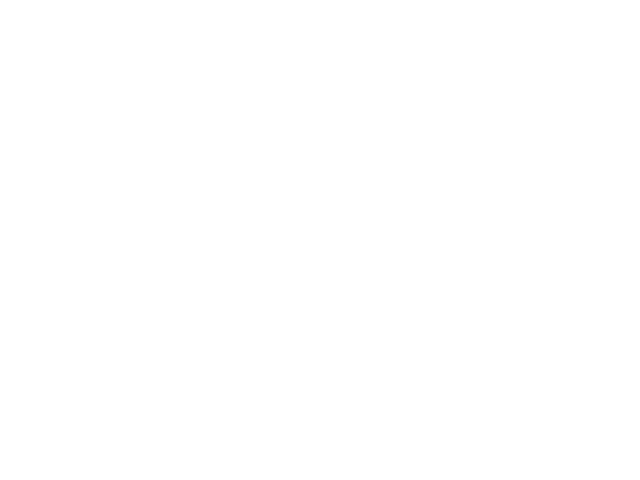

In [17]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib notebook





bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
)

i = 0
# for for_draw in skels_for_draw:
i = i + 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for_draw = skels_for_draw[10]

for pair in bone_pairs:
    xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
    ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
    zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

    line = plt3d.art3d.Line3D(zs, xs, ys)
    ax.add_line(line)


for x,y,z in for_draw:
    ax.scatter(z, x, y, color='black', marker='s')

    ax.set_ylim((-0.03, 0.03))
    ax.set_zlim((-0.01, 0.004))
    ax.set_xlim((0.032, 0.036))


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    plt.show()

# plt.savefig('pics_1/test_' +str(i)+'.png', bbox_inches='tight')
#     plt.clf()

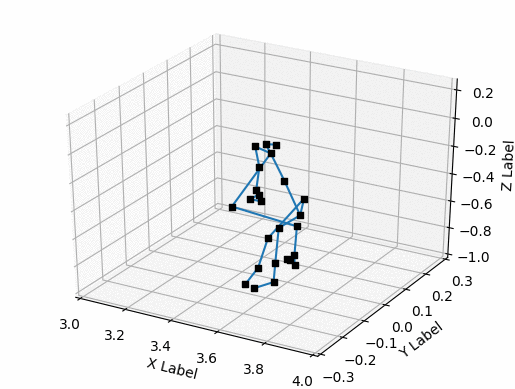

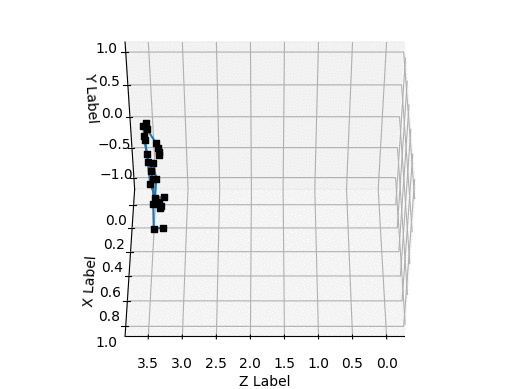

In [18]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),int(0.25*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [19]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [21]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()

In [22]:
sket_tensor.size()

torch.Size([1, 45, 75])

In [23]:
output = rnn(sket_tensor.to(device))

In [24]:
output.topk(5)

torch.return_types.topk(
values=tensor([[ 0.1324,  0.0943,  0.0318, -0.0055, -0.0934]], grad_fn=<TopkBackward>),
indices=tensor([[1, 3, 0, 2, 4]]))

In [25]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(800):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            #####сделать более аккуратный вывод для каждой эпохии
            ######сделать обновление графика loss по ходу обучению  
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.6242  / jump up ✗ (sitting down)
epoch : 16 iter : 20 (0m 38s) 1.6090  / sitting down ✗ (jump up)
epoch : 33 iter : 10 (1m 17s) 1.6032  / sitting down ✓
epoch : 50 iter : 0 (1m 56s) 1.5855  / hand waving ✗ (sitting down)
epoch : 66 iter : 20 (2m 34s) 1.5972  / hand waving ✗ (cheer up)
epoch : 83 iter : 10 (3m 13s) 1.6105  / hand waving ✗ (clapping)
epoch : 100 iter : 0 (3m 51s) 1.5878  / hand waving ✗ (jump up)
epoch : 116 iter : 20 (4m 30s) 1.6397  / hand waving ✗ (clapping)
epoch : 133 iter : 10 (5m 8s) 1.5922  / hand waving ✓
epoch : 150 iter : 0 (5m 47s) 1.5810  / hand waving ✓
epoch : 166 iter : 20 (6m 26s) 1.5984  / hand waving ✗ (clapping)
epoch : 183 iter : 10 (7m 5s) 1.5871  / hand waving ✓
epoch : 200 iter : 0 (7m 44s) 1.5834  / hand waving ✓
epoch : 216 iter : 20 (8m 23s) 1.5964  / hand waving ✓
epoch : 233 iter : 10 (9m 2s) 1.5984  / hand waving ✗ (clapping)
epoch : 250 iter : 0 (11m 38s) 1.6424  / hand waving ✗ (sitting down)
epoch : 266 iter :

<IPython.core.display.Javascript object>


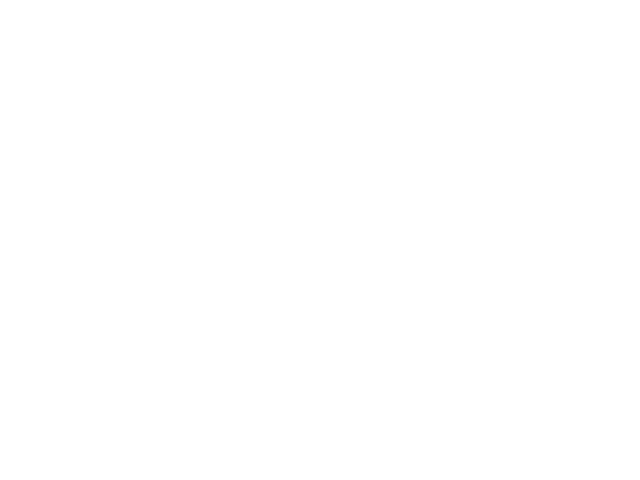

In [26]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [27]:
total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   10.0


### Модуль transform

https://pytorch.org/docs/stable/torchvision/transforms.html

In [28]:
from PIL import Image
%matplotlib inline


img = Image.open('cat.png')

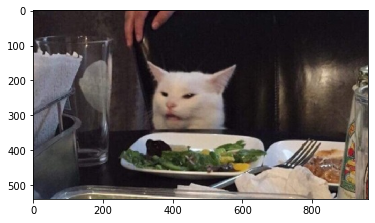

In [29]:
plt.imshow(img)
plt.show()

In [30]:
type(img)

PIL.PngImagePlugin.PngImageFile

In [31]:
img_0 = img.copy()

In [32]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(256)
        ])

In [33]:
img_crop = data_transforms(img_0)

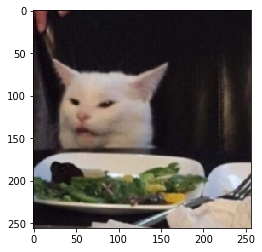

In [34]:
plt.imshow(img_crop)
plt.show()

In [35]:
img_1 = img.copy()

In [36]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomRotation(30)
])

In [37]:
img_center_crop = transformations(img_1)

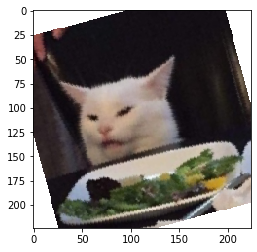

In [38]:
plt.imshow(img_center_crop)
plt.show()

### Домашнее задание

**1. "Необходимо нормализовать данные в датасете: написать функцию нормализации и использовать ее внутри класса датасета"**

Добавил следующую часть:

    class Skeleton_Dataset(Dataset):
        def __init__(self, file_path, transform=None):
            self.data = pd.read_csv(file_path)
            self.transform = transform

        def __len__(self):
            return len(self.data) 

        def __getitem__(self, idx):
            item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
            label = self.data.iloc[idx,-1]

    -->     if self.transform != None:
    -->          item = normalize(item, axis=1, norm='l1')

            return (item, label) 
            
    dataset = Skeleton_Dataset(file_path = "skels.csv", --> transform=True <--)

**получилась такая картинка:**

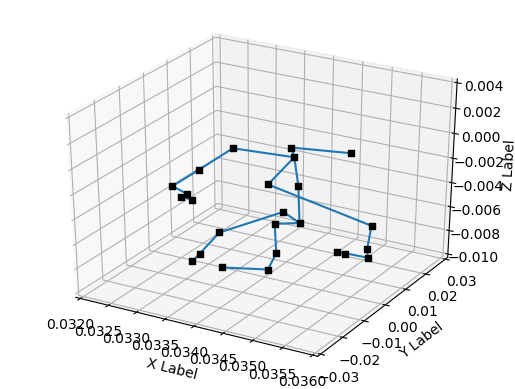

**2. "Дополнительное задание: <br> http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption - <br>2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).<br> Проделайте весь путь подготовки данных, создания датасета, разделения и обучения модели самостоятельно.<br> Предсказывать нужно Global_active_power."**

In [39]:
energy_consumption_path = "./power_consumption/household_power_consumption.txt"
energy_consumption = pd.read_csv(energy_consumption_path, sep=";", parse_dates=[['Date', 'Time']])
energy_consumption = energy_consumption.set_index(['Date_Time'])

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
#replace all '?' values to None
energy_consumption = energy_consumption.replace(['?'], None)

In [41]:
#all columns were objects, so change them to float
energy_consumption = energy_consumption.astype(np.float64)

In [42]:
energy_consumption.head()

Global_active_power  Global_reactive_power  Voltage  \
Date_Time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Date_Time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
Date_Time                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [43]:
energy_consumption.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.086168e+00           1.233280e-01  2.408416e+02   
std           1.053172e+00           1.125144e-01  3.235574e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.390000e+02   
50%           5.980000e-01           1.000000e-01  2.410200e+02   
75%           1.524000e+00           1.940000e-01  2.428700e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.075259e+06    2.075259e+06    2.075259e+06    2.049280e+06  
mean       4.604226e+00    1.110995e+00    1.287958e+00    6.458447e+00  
std        4.426775e+00    6.115908e+00    5.786865e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

In [44]:
energy_consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [45]:
energy_consumption = energy_consumption.dropna()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


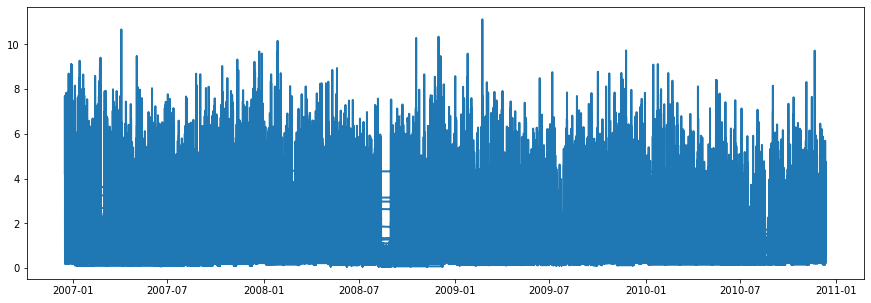

In [46]:
plt.figure(figsize = (15,5))
plt.plot(energy_consumption['Global_active_power'], linewidth=2.0)

<Figure size 1080x360 with 0 Axes>

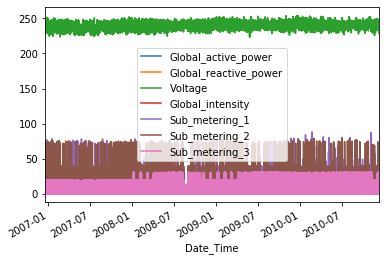

In [47]:
plt.figure(figsize = (15,5))
energy_consumption.plot()

In [86]:
class Energy_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data = dataset
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        label = self.data['Global_active_power']
        item = np.asarray(self.data.drop(['Global_active_power'], axis='columns')) 
        #self.transform(item[idx]), self.transform(label[idx])
        #self.transform = transforms.Compose([transforms.ToTensor()])
        
        if self.transform != None:
            item = normalize(item, axis=1, norm='l1')

        return (item, label) 

In [87]:
energy = Energy_Dataset(dataset = energy_consumption, transform=None)

In [88]:
feature, label = energy.__getitem__(11)
feature

array([[  0.418, 234.84 ,  18.4  ,   0.   ,   1.   ,  17.   ],
       [  0.436, 233.63 ,  23.   ,   0.   ,   1.   ,  16.   ],
       [  0.498, 233.29 ,  23.   ,   0.   ,   2.   ,  17.   ],
       ...,
       [  0.   , 239.82 ,   3.8  ,   0.   ,   0.   ,   0.   ],
       [  0.   , 239.7  ,   3.8  ,   0.   ,   0.   ,   0.   ],
       [  0.   , 239.55 ,   3.8  ,   0.   ,   0.   ,   0.   ]])

In [89]:
train_dataset, test_dataset = torch.utils.data.random_split(energy, [int(0.75*len(energy)),int(0.25*len(energy))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [76]:
for i, data in enumerate(train_loader):
        print(data[0], data[1])

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.series.Series'>

In [55]:
n_hidden = 128
n_joints = 6
#n_categories = len(LABELS) # а что сюда?
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,1,n_layer) #n_categories = 1
rnn.to(device)

LSTM_net(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [53]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [71]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(800):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 

        current_loss += loss.item()
        category = labels[0]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            #####сделать более аккуратный вывод для каждой эпохии
            ######сделать обновление графика loss по ходу обучению  
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.series.Series'>